Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== LOADING DATASETS ===

=== DATE PARSING & PREPROCESSING ===

=== TREND PLOTS ===


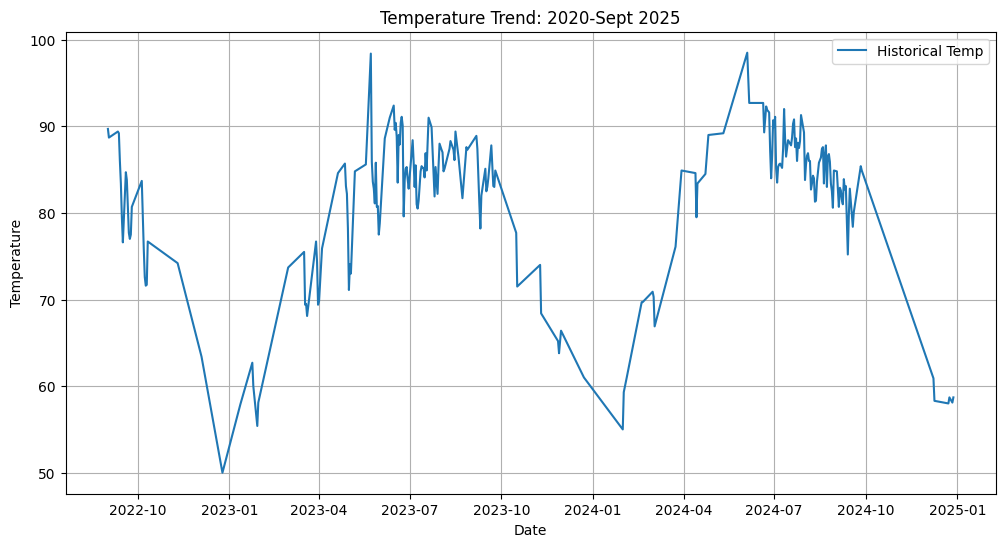


=== TRAINING RANDOM FOREST MODEL ===

=== PREDICTING OCTOBER 2025 TEMPERATURES ===

=== RESULTS TABLE (First 10 Days) ===
      Date  Actual Temperature  Predicted Temperature  Error
2025-01-01                50.8                  82.19  31.39
2025-01-02                50.9                  57.26   6.36
2025-01-03                53.7                  57.46   3.76
2025-01-04                54.9                  57.46   2.56
2025-01-05                53.7                  58.33   4.63
2025-01-06                54.7                  57.48   2.78
2025-01-07                54.2                  58.02   3.82
2025-01-08                55.0                  57.82   2.82
2025-01-09                55.6                  58.21   2.61
2025-01-10                53.3                  58.38   5.08

Mean Absolute Error (MAE): 2.86
Root Mean Squared Error (RMSE): 3.82
Model Accuracy: 96.31 %


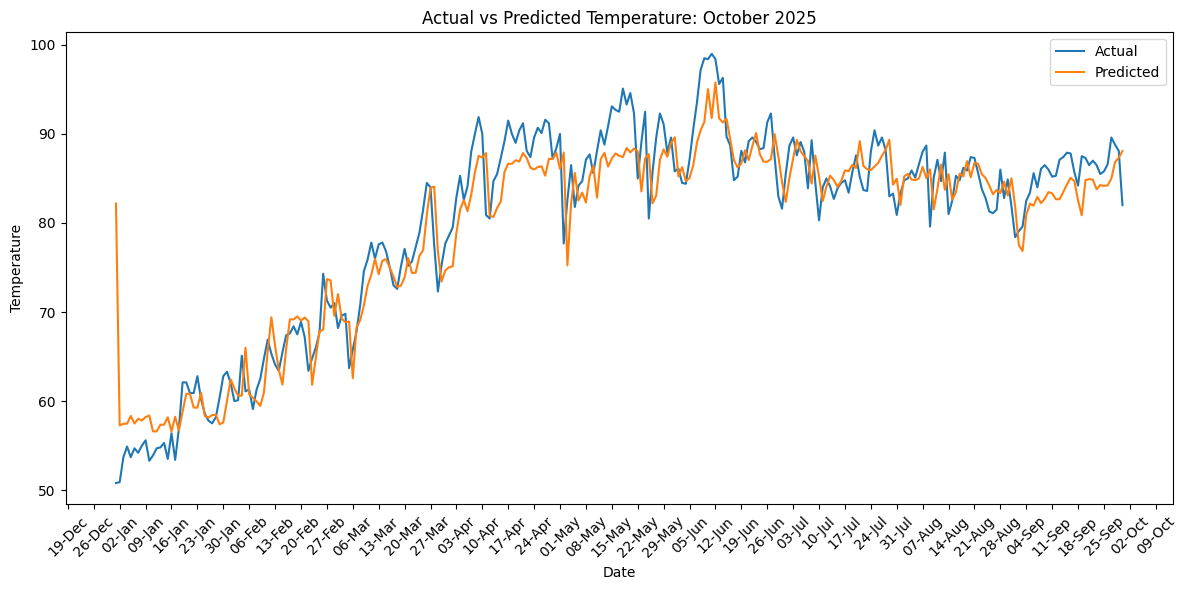

In [ ]:
# Step 1: Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Step 2: Load datasets
print("\n=== LOADING DATASETS ===")
hist_path = '/content/drive/MyDrive/vityarthiproj/dataset1.csv'   # Historical data (2020-Sept 2025)
oct_path  = '/content/drive/MyDrive/vityarthiproj/dataset2.csv'   # Actual October 2025 temp data
data_hist = pd.read_csv(hist_path)
data_oct  = pd.read_csv(oct_path)

# Step 3: Parse date columns with dayfirst format and sort
print("\n=== DATE PARSING & PREPROCESSING ===")
data_hist['datetime'] = pd.to_datetime(data_hist['datetime'], dayfirst=True)
data_oct['datetime']  = pd.to_datetime(data_oct['datetime'], dayfirst=True)
data_hist = data_hist.sort_values('datetime')
data_oct  = data_oct.sort_values('datetime')

# Step 4: Feature engineering - extract year, month, day; create lag feature for previous day temp
data_hist['year'] = data_hist['datetime'].dt.year
data_hist['month'] = data_hist['datetime'].dt.month
data_hist['day'] = data_hist['datetime'].dt.day
data_hist['temp_prev_day'] = data_hist['temp'].shift(1)  # previous day's temperature
data_hist = data_hist.dropna()  # drop first row with NaN lag temp

# Optional plot of historical trend for report/analysis
print("\n=== TEMPERATURE TREND: 2020-Sept 2025 ===")
plt.figure(figsize=(12,6))
plt.plot(data_hist['datetime'], data_hist['temp'], label="Historical Temp")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature Trend: 2020-Sept 2025")
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Prepare October data similarly
data_oct['year'] = data_oct['datetime'].dt.year
data_oct['month'] = data_oct['datetime'].dt.month
data_oct['day'] = data_oct['datetime'].dt.day

# Attach previous day's temperature for the first day of October using last day of September
data_oct = data_oct.sort_values('datetime')
oct_with_prev = data_oct.copy()
# First October day uses last September day's temp as lag
oct_with_prev['temp_prev_day'] = data_hist[data_hist['datetime'].dt.month == 9].iloc[-1]['temp']
# Fill lag feature for remaining days using previous October temps
for i in range(1, len(oct_with_prev)):
    oct_with_prev.iloc[i, oct_with_prev.columns.get_loc('temp_prev_day')] = oct_with_prev.iloc[i-1]['temp']

# Feature columns for input to model
feature_cols = ['year', 'month', 'day', 'temp_prev_day']

# Step 6: Split training (up to Sept 2025) and testing (October 2025)
train = data_hist[data_hist['datetime'] < '2025-10-01']
X_train = train[feature_cols]
y_train = train['temp']
X_test = oct_with_prev[feature_cols]
y_test = oct_with_prev['temp']

# Step 7: Train model
print("\n=== TRAINING RANDOM FOREST REGRESSOR ===")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 8: Predict October 2025 temperatures
print("\n=== PREDICTING OCTOBER 2025 TEMPERATURES ===")
y_pred = model.predict(X_test)

# Step 9: Show results - table with actual, predicted, error
print("\n=== RESULTS TABLE (First 10 Days) ===")
results = pd.DataFrame({
    'Date': oct_with_prev['datetime'],  # keep datetime for plotting
    'Actual Temperature': y_test.round(2),
    'Predicted Temperature': y_pred.round(2),
    'Error': (y_pred - y_test).round(2)
})
print(results.head(10).to_string(index=False))  # top 10 for brevity

# Step 10: Calculate and display error metrics
mae = np.mean(np.abs(y_pred - y_test))
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
accuracy = 100 - mape

print(f"\nMean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Model Accuracy: {accuracy:.2f} %")

# Step 11: Visualize actual vs predicted temperatures for October 2025
plt.figure(figsize=(12,6))
plt.plot(results['Date'], results['Actual Temperature'], label='Actual')
plt.plot(results['Date'], results['Predicted Temperature'], label='Predicted')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Actual vs Predicted Temperature: October 2025")
plt.legend()

# Fix x-axis with weekly date ticks for clarity
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
